In [76]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd   
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.metrics import accuracy_score, log_loss
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTE

In [63]:
train = pd.read_csv('../Data/train_2.csv', index_col = 'Unnamed: 0')
test = pd.read_csv('../Data/test_2.csv', index_col = 'Unnamed: 0')

In [80]:
submission = pd.read_csv('../Data/sample_submission.csv')

credit 0 : 2865
credit 1 : 5691
credit 2 : 15542


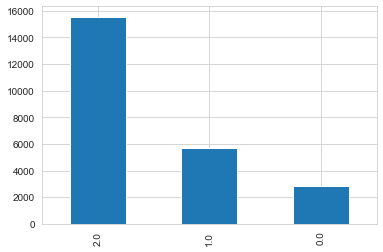

In [64]:
sns.set_style('whitegrid')
train['credit'].value_counts().plot(kind = 'bar')

print('credit 0 : {}'.format(train['credit'].value_counts()[0]))
print('credit 1 : {}'.format(train['credit'].value_counts()[1]))
print('credit 2 : {}'.format(train['credit'].value_counts()[2]))

In [65]:
train_x = train.drop(['credit', 'index'], axis = 1)
train_y = train[['credit']]
test_x = test.drop(['index'], axis = 1)

# **ENCODING**

In [66]:
encoder = OrdinalEncoder()
encoder.fit(train_x[['child_num','family_size']])

train_x[['child_num','family_size']] = encoder.transform(train_x[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [67]:
encoder.fit(test_x[['child_num','family_size']])

test_x[['child_num','family_size']] = encoder.transform(test_x[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [68]:
train_x = pd.get_dummies(train_x,drop_first= True)
test_x = pd.get_dummies(test_x,drop_first= True)

In [69]:
print(train_x.shape, test_x.shape, train_y.shape)

(24098, 35) (10000, 35) (24098, 1)


In [70]:
sm = SMOTE()

X_resampled, y_resampled = sm.fit_resample(train_x,train_y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_resampled.shape))

After OverSampling, the shape of train_X: (46626, 35)
After OverSampling, the shape of train_y: (46626, 1)


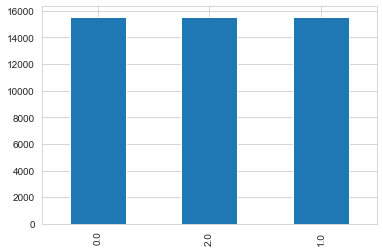

In [71]:
sns.set_style('whitegrid')
y_resampled['credit'].value_counts().plot(kind = 'bar')
plt.show()

In [72]:
print(train_x.shape, test_x.shape, train_y.shape)

(24098, 35) (10000, 35) (24098, 1)


## **모델링**

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                    stratify=y_resampled, test_size=0.25,
                                                    random_state = 2021)


In [88]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.11, iterations = 530)
cat_pred.fit(X_train, y_train, silent= True)
y_pred=cat_pred.predict(X_train)
#print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

In [77]:
def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(X_resampled, y_resampled)):
        X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
        y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
        clf.fit(X_train, y_train, silent= True)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_pred)

FOLD 0 : logloss:0.7057762011543542
FOLD 1 : logloss:0.7075207346361045
FOLD 2 : logloss:0.7104217522391054
FOLD 3 : logloss:0.7070005536050399
FOLD 4 : logloss:0.7055973847881299
Mean:0.7072633252845468


In [81]:
submission.loc[:,1:] = my_submission

In [82]:
submission

,index,0,1,2
0,26457,0.130338,0.138738,0.730924
1,26458,0.210228,0.138154,0.651619
2,26459,0.115750,0.118395,0.765856
3,26460,0.236911,0.183124,0.579965
4,26461,0.076793,0.199391,0.723816
...,...,...,...,...
9995,36452,0.296618,0.219544,0.483838
9996,36453,0.102120,0.371276,0.526605
9997,36454,0.074614,0.153088,0.772298
9998,36455,0.309018,0.200289,0.490692


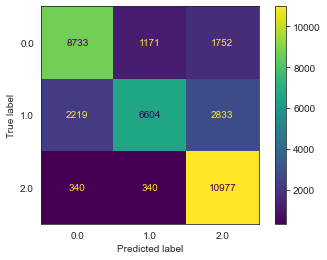

In [89]:
sns.set_style('white')
plot_confusion_matrix(cat_pred, X_train, y_train)
plt.show()

In [90]:
confusion_matrix(y_train, y_pred)

array([[ 8733,  1171,  1752],
       [ 2219,  6604,  2833],
       [  340,   340, 10977]], dtype=int64)

In [92]:
accuracy_score(y_train, y_pred)

0.7524950670593955

In [91]:
submission.to_csv('../Data/Oversampling.csv', index=False)